# NYC subway turnstile entries for 2016
This code cleans NYC subway turnstile data to so a model can be trained on January-November statrion entry numbers and then predict December entries by day and by station. 

In [1]:
import datetime as dt
import calendar as cal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from time import perf_counter

from IPython.display import display, HTML

import config as c

## Read in all ~9.5 million rows of NYC subway turnstile data for 2016
* This drops columns that are not necessary for the analysis

In [2]:
dtypes = {'Entries': 'int64', 'Exits': 'int64'}
df= pd.read_csv('../intermediate data/Turnstile_Usage_Data__2016.csv', dtype=dtypes, low_memory=False)
df.columns = df.columns.str.strip().str.lower().str.replace('/', '')
df.drop(columns=['line name', 'division', 'description', 'exits'], inplace=True)
print(df.dtypes)
display(HTML(df.head(10).to_html()))

ca         object
unit       object
scp        object
station    object
date       object
time       object
entries     int64
dtype: object


,ca,unit,scp,station,date,time,entries
0,A002,R051,02-00-00,59 ST,12/30/2016,23:00:00,5991455
1,A002,R051,02-00-00,59 ST,12/30/2016,19:00:00,5991003
2,A002,R051,02-00-00,59 ST,12/30/2016,15:00:00,5989931
3,A002,R051,02-00-00,59 ST,12/30/2016,07:00:00,5989153
4,A002,R051,02-00-00,59 ST,12/30/2016,03:00:00,5989126
5,A002,R051,02-00-00,59 ST,12/29/2016,23:00:00,5989038
6,A002,R051,02-00-00,59 ST,12/29/2016,19:00:00,5988591
7,A002,R051,02-00-00,59 ST,12/29/2016,15:00:00,5987660
8,A002,R051,02-00-00,59 ST,12/29/2016,11:00:00,5987299
9,A002,R051,02-00-00,59 ST,12/29/2016,07:00:00,5987115


## Loop through all data, cleaning it by station, then aggregating it by station and date.
This allows a smaller amount of memory to be used to clean and aggregate the data, thus resulting in a much smaller output dataset

In [3]:
stations = df.station.unique()
n=0
nTotal = len(stations)

tt0 = perf_counter()

# Loop through stations to process smaller chunks of data at a time
for s in stations:
    t0 = perf_counter()
    n+=1
    
    # Print out info on station name and number in this dataset
    print('\n{}/{} | {} '.format(n, nTotal, s), end='\n')
    
    # Get slice of dataframe for each station, s
    dfStation = df[df['station']==s].copy()  

    # Make turnstile column, concatenate ca, unit, and scp fields
    dfStation['turnstile'] = dfStation['ca'] + ' ' +  dfStation['unit'] + ' ' + dfStation['scp']
    
    # Make date column a datetime object
    dfStation['datetime'] = pd.to_datetime(dfStation['date']  + ' ' + dfStation['time'])
    dfStation['date'] = pd.to_datetime(dfStation['date'])

    # Sort data for following entry calculations
    dfStation.sort_values(by=['turnstile', 'station', 'datetime'], inplace=True)

    # Calculate time interval
    dfStation['interval'] = dfStation['datetime'] - dfStation['datetime'].shift(1)
    
    # Calculate entries per time period
    dfStation['enterDiff'] = dfStation['entries'] - dfStation['entries'].shift(1)
    
    # Calculate entries per minute
    dfStation['intMin'] = dfStation['interval'] / np.timedelta64(1, 'm') 
    dfStation['entriesPerMin'] = dfStation['enterDiff'] / dfStation['intMin']
    
    # Clean up the dataframe - drop unneeded columns
    dfStation.drop(columns=['ca', 'unit', 'scp', 'time', 'entries'], inplace=True)
    
    # Find first occurance of each turnstile
    dfStation['firstSCP'] = ~ (dfStation['turnstile'] == dfStation['turnstile'].shift(1))
    
    # Remove bad data first occurances of turnstiles and negative entry numbers, NaNs,
    # where entires per minute > 30 (because let's be honest, more than 1 person
    # entering every 2 seconds is outrageous)
    before = dfStation.shape[0]
    print('Records before cleaning: {}'.format(before))
    dfStation = dfStation[(dfStation['firstSCP'] == False) & 
                          (dfStation['enterDiff']>=0) & 
                          (dfStation['entriesPerMin']<=30) &
                          (dfStation['intMin'] <= 300)].dropna(subset=['enterDiff'])
    after = dfStation.shape[0]
    print('Records after cleaning:  {}'.format(after))
    print('Retained {}% of records'.format(round(after/before*100, 2)))

#     plt.hist(dfStation['entriesPerMin'], range=[0, 30], bins=60, label='Entries Per Minute')
#     plt.yscale('log', nonposy='clip')
#     plt.xlabel('Entries Per Minute During reportying time period')
#     plt.ylabel('Samples in Data Set')
#     plt.legend()
#     plt.show()
    
    # Remove fields used only to clean the data
    dfStation.drop(columns=['turnstile', 'datetime', 'interval', 'intMin', 'entriesPerMin', 'firstSCP'],
                  inplace=True)
    
    # Calculate daily entries per station
    dfStationDay = dfStation.groupby(['station', 'date']).sum().reset_index()
    dfStationDay.rename(columns={'enterDiff': 'totalEntries'}, inplace=True)
    #display(HTML(dfStationDay.head(10).to_html()))
    print('Rows: {} (Grouped by station and day)'.format(dfStationDay.shape[0]))
    
    
    # Add data grouped by station and day to new df
    try:
        dfCleaned = dfCleaned.append(dfStationDay)
    except: 
        dfCleaned = dfStationDay
        
    print('Duration: {} sec.'.format(round(perf_counter() - t0, 2)))
    
    if n%5 == 0:
        intTime = round(perf_counter() - tt0, 2)
        print('\nINTERMEDIATE Duration: {} sec.'.format(intTime))
        remainingTime = round(intTime / n * (nTotal - n), 2)
        print('Estimated time remaining: {} sec.'.format(remainingTime))
    
    # This if statment is used in testing the code, to process a smaller
    # amount of data, allowing for faster iteration of code updates
    if n>=2: 
        print('THE ABOVE IS A SAMPLE OF DATA OUTPUT FOR COMMUNICATION PURPOSES\n \
              BELOW IS ANALYSES PERFORMED ON THE FULL DATASET')
        break

dfCleaned.sort_values(by=['date', 'station'], inplace=True)
#display(HTML(dfCleaned.head(10).to_html()))

print('TOTAL Duration: {} sec.'.format(round(perf_counter() - tt0, 2)))
print(dfCleaned.shape)
cleanedDataCSV = '../intermediate data/dfCleaned.csv'
dfCleaned.to_csv(cleanedDataCSV, index=False)
del dfCleaned


1/376 | 59 ST 
Records before cleaning: 108842
Records after cleaning:  105908
Retained 97.3% of records
Rows: 336 (Grouped by station and day)
Duration: 9.0 sec.

2/376 | 5 AV/59 ST 
Records before cleaning: 29184
Records after cleaning:  28494
Retained 97.64% of records
Rows: 336 (Grouped by station and day)
Duration: 2.52 sec.
THE ABOVE IS A SAMPLE OF DATA OUTPUT FOR COMMUNICATION PURPOSES
               BELOW IS ANALYSES PERFORMED ON THE FULL DATASET
TOTAL Duration: 11.52 sec.
(672, 3)


## Group entry data by day and plot it to see if it makes sense

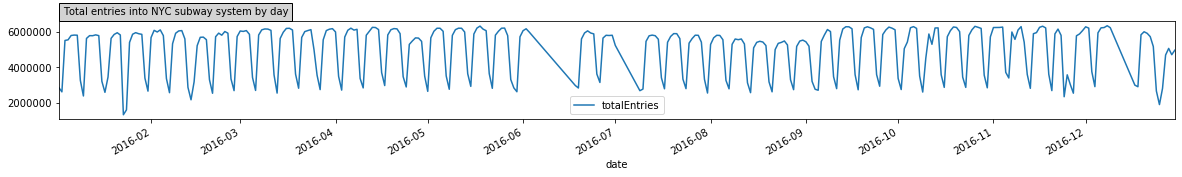

In [4]:
cleanedDataCSV = '../intermediate data/dfCleaned_bak.csv'

dfClean = pd.read_csv(cleanedDataCSV, parse_dates=['date'])
dfClean.drop(columns=['station'], inplace=True)

dfByDay = dfClean.groupby(['date']).sum().reset_index()
dfByDay.sort_values(by=['date'], inplace=True)

titleText = 'Total entries into NYC subway system by day'
fig, ax = plt.subplots(figsize=(20, 2))
dfByDay.plot.line(ax=ax, x='date', y='totalEntries', figsize=(20,2))
ax.text(0.0035,1.15,titleText, 
        ha='left', va='top',
        color='black',
        bbox=dict(facecolor='lightgray', alpha=1),
        transform = ax.transAxes)
plt.show()

## Add columns to identify days of the week - For training the model
* 1 = True, i.e. row is that day
* 0 = False, i.e. row is not that day

In [5]:
dfByDay['weekday'] = dfByDay['date'].dt.day_name()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for d in days:
    dfByDay[d] = 0
    dfByDay.loc[dfByDay['weekday'] == d, d] = 1

dfByDay.drop(columns=['weekday'], inplace=True)
display(HTML(dfByDay.head(10).to_html()))

,date,totalEntries,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2016-01-02,2854758.0,0,0,0,0,0,1,0
1,2016-01-03,2613487.0,0,0,0,0,0,0,1
2,2016-01-04,5498848.0,1,0,0,0,0,0,0
3,2016-01-05,5532524.0,0,1,0,0,0,0,0
4,2016-01-06,5777060.0,0,0,1,0,0,0,0
5,2016-01-07,5800428.0,0,0,0,1,0,0,0
6,2016-01-08,5792994.0,0,0,0,0,1,0,0
7,2016-01-09,3257278.0,0,0,0,0,0,1,0
8,2016-01-10,2382600.0,0,0,0,0,0,0,1
9,2016-01-11,5611969.0,1,0,0,0,0,0,0


## Split data into training and testing sets
* Training set = January through November
* Testing set = December

In [6]:
dfTrain = dfByDay[dfByDay['date']< '2016-12-1'].copy()
dfTest = dfByDay[dfByDay['date']>= '2016-12-1'].copy()

dfTrain.set_index('date', inplace=True)
dfTest.set_index('date', inplace=True)

## Fit a linear regression model to training set

In [7]:
from sklearn.linear_model import LinearRegression

trainDays = dfTrain.drop(columns=['totalEntries'])
trainEntries = dfTrain['totalEntries']

model = LinearRegression(fit_intercept = False)
model.fit(trainDays, trainEntries)
dfTrain['predicted'] = model.predict(trainDays)

display(HTML(dfTrain.head(5).to_html()))

,totalEntries,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,predicted
date,,,,,,,,,
2016-01-02,2854758.0,0,0,0,0,0,1,0,3.332914e+06
2016-01-03,2613487.0,0,0,0,0,0,0,1,2.712691e+06
2016-01-04,5498848.0,1,0,0,0,0,0,0,5.323048e+06
2016-01-05,5532524.0,0,1,0,0,0,0,0,5.841929e+06
2016-01-06,5777060.0,0,0,1,0,0,0,0,5.964880e+06


## Plot the regression model on top of entry data to visually examine fit

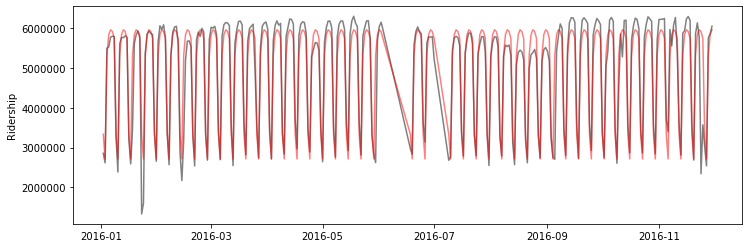

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(dfTrain['totalEntries'], color='gray', alpha=1)
ax.plot(dfTrain['predicted'], color='red', alpha=0.5)
ax.set_ylabel('Ridership')
ax.set_xticks
plt.show()